<a href="https://colab.research.google.com/github/FG2511/ARE/blob/master/model1_Francesca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
'''
@File name: model1.ipynb
@Created on 2018-12-20
@Authors: Federica Gerina, Francesca Moi, Silvia Maria Massa
@Description: Given a time-series dataset that contains minute-by-minute data 
about different kind of gases, collected by the uHoo air quality sensor, train
a NN that classifies if a minute belongs to the class "Pasto" (1) otherwise to
the class "Other" (0).
'''

!pip install liac-arff

import arff
import csv

import numpy as np
from numpy import savetxt

import pandas as pd
from pandas import DataFrame
from pandas import read_csv
from pandas import concat

from keras import optimizers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.pyplot import legend


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [0]:
#layers : 57, 113, 226, 1 (regola: input/2, input, 2*input, 1)
#layers : 113, 229, 153, 1 (regola: a= input, b= a*2/3+c, c= b*2/3+1)

def generate_model_leaky(shape):
  
  model = Sequential()
  model.add(BatchNormalization())
  
  model.add(Dense(113, input_dim=shape, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(229, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(153, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [0]:
#layers : 57, 113, 226, 1 (regola: input/2, input, 2*input, 1)
#layers : 113, 229, 153, 1 (regola: a= input, b= a*2/3+c, c= b*2/3+1)

def generate_model(shape):
  
  model = Sequential()
  model.add(BatchNormalization())
  
  model.add(Dense(113, input_dim=shape, use_bias=False, kernel_initializer='random_uniform'))#, activation='relu'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))  
  
  model.add(Dense(229, use_bias=False, kernel_initializer='random_uniform')) #, activation='relu'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(153, use_bias=False, kernel_initializer='random_uniform')) #, activation='relu'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))  
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [102]:
#LOAD DATA
print("Loading data...")

dataset = '/root/data/6_uHoo_featureDataset.arff'

with open (dataset, encoding='utf-8') as f:
  dataDictionary = arff.load(f)

data = np.array(dataDictionary['data'])
print("DATASET LOADED")

#CONVERTING VALUES
print("Converting values...")
for i in data:
  if(i[-1] == 'Other'): i[-1] = 0
  elif(i[-1] == 'Pasto') : i[-1] = 1

dataset = data.astype('float32')
print("CONVERSION DONE")

Loading data...
DATASET LOADED
Converting values...
CONVERSION DONE


In [0]:
#SPLIT INTO INPUT (X) AND OUTPUT (Y) VARIABLES
s = dataset.shape[-1]
#print(s)
X = dataset[:,0:s-1]
Y = dataset[:,s-1]

#SPLIT INTO TRAINING, VALIDATION AND TEST SETS
train_rate = 80
val_rate = 10
train = round(int((dataset.shape[0]*train_rate)/100))
val = round(int((dataset.shape[0]*(train_rate+val_rate))/100))

train_data = X[:train]
train_label = Y[:train]

val_data = X[train+1:val]
val_label = Y[train+1:val]

test_data = X[val+1:]
test_label = Y[val+1:]


In [104]:
#COMPUTE CLASS WEIGHT
labels = np.unique(train_label)
classWeight = compute_class_weight('balanced', labels, train_label)
classWeight = dict(zip(labels,classWeight))

#GENERATE MODEL
model = generate_model_leaky(train_data.shape[-1])
#model = generate_model(train_data.shape[-1])

#OPTIMIZERS
adm = optimizers.Adam(lr=0.0001)

#COMPILE MODEL
model.compile(loss='binary_crossentropy', optimizer = adm , metrics=['accuracy'])

#EARLY STOPPING
#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

#FIT MODEL
history = model.fit(train_data, train_label, epochs=20, validation_data = (val_data, val_label), batch_size = 128, shuffle = True, class_weight = classWeight, verbose=1)#, callbacks = [es])

#EVALUATE MODEL
scores_test = model.evaluate(test_data, test_label, batch_size=128, verbose = 1)
print("Test loss: %.2f%%" % (scores_test[0] * 100))
print("Test accuracy: %.2f%%" % (scores_test[1] * 100))

#CALCULATE PREDICTIONS AND SAVE IN A CSV FILE
pred = model.predict_classes(test_data, batch_size=128, verbose=0)

Train on 183944 samples, validate on 22992 samples
Epoch 1/20
183944/183944 [==============================] - 18s 99us/step - loss: 0.6750 - acc: 0.6531 - val_loss: 0.5893 - val_acc: 0.7143
Epoch 2/20
183944/183944 [==============================] - 15s 84us/step - loss: 0.5927 - acc: 0.7178 - val_loss: 0.5260 - val_acc: 0.7472
Epoch 3/20
183944/183944 [==============================] - 15s 82us/step - loss: 0.5520 - acc: 0.7359 - val_loss: 0.4785 - val_acc: 0.7724
Epoch 4/20
183944/183944 [==============================] - 15s 82us/step - loss: 0.5260 - acc: 0.7464 - val_loss: 0.4406 - val_acc: 0.8017
Epoch 5/20
183944/183944 [==============================] - 15s 84us/step - loss: 0.5087 - acc: 0.7490 - val_loss: 0.4674 - val_acc: 0.7844
Epoch 6/20
183944/183944 [==============================] - 16s 87us/step - loss: 0.4956 - acc: 0.7574 - val_loss: 0.4839 - val_acc: 0.7683
Epoch 7/20
183944/183944 [==============================] - 15s 81us/step - loss: 0.4835 - acc: 0.7625 - val_

In [105]:
y_true = test_label
tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
(tn, fp, fn, tp)
other = 100*tn/(tn+fp)
pasto = 100*tp/(fn+tp)
print("Other: %.2f %%" % other)
print("Pasto: %.2f %%" % pasto)

Other: 72.44 %
Pasto: 52.48 %


In [0]:
#model.save('my_model1.h5')
#model = load_model('my_model.h5')

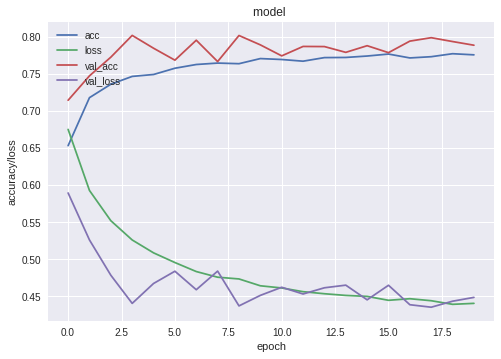

"plt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()"

In [107]:
#PLOT RESULTS

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('model ')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['acc', 'loss', 'val_acc', 'val_loss'], loc='upper left')
plt.show()

# summarize history for loss
'''plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()'''
